In [1]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import MultiSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import MultipleSystemOptimizer as MultiSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.springs import SpringFF, _random_spring_systems, _random_spring_ff_param
import torch
import copy

systemN = 40
N = 20
N_pairs = 100
max_Za = 3
Ras, Zas, idx_is, idx_js = _random_spring_systems(systemN, N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_spring_ff_param(max_Za, r0_max=5, k_max=5)
ff = SpringFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0, 1, 2]
graph_builders = [get_given_graph_builder(idx_i, idx_j) for idx_i, idx_j in zip(idx_is, idx_js)]

# start implicit optimization
params_star = ff.state_dict()
params_goal = copy.deepcopy(params_star)
print("params_star", params_star)
optimizer = MultiSystemOptimizer(
    Ras, Zas, graph_builders, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)


optimizer_Energy = MultiSystemOptimizer_Energy(
    Ras, Zas, graph_builders, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)


k_perturbed = -k.clone() + 3*torch.randn_like(k)
r0_perturbed = torch.clamp(r0.clone() + torch.randn_like(r0) * 3, min=0)
ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)
print("params_0", params_0)
new_params_0=optimizer.optimize_Adam(3000,params_0)
print("params_optimized",new_params_0)

params_star OrderedDict([('k', tensor([[4.8169, 2.2606, 4.2819, 1.2743],
        [2.2606, 3.4736, 1.6572, 1.3722],
        [4.2819, 1.6572, 3.8401, 1.6750],
        [1.2743, 1.3722, 1.6750, 2.9694]], dtype=torch.float64)), ('r0', tensor([[4.1941, 3.9476, 3.8544, 2.3313],
        [3.9476, 3.4621, 2.7016, 3.8542],
        [3.8544, 2.7016, 1.3412, 2.3038],
        [2.3313, 3.8542, 2.3038, 2.7776]], dtype=torch.float64))])
params_0 OrderedDict([('k', tensor([[-6.0083, -3.5052, -4.9126, -2.1332],
        [-3.5052, -3.0817,  0.1792,  2.7875],
        [-4.9126,  0.1792, -4.1454, -4.4785],
        [-2.1332,  2.7875, -4.4785, -2.4024]], dtype=torch.float64)), ('r0', tensor([[2.1908, 2.1780, 3.2710, 5.2775],
        [2.1780, 4.7487, 2.0157, 3.7063],
        [3.2710, 2.0157, 3.9961, 1.1592],
        [5.2775, 3.7063, 1.1592, 0.9096]], dtype=torch.float64))])


/Users/soonhyun/Desktop/GeometryOptimization/Landscape_Fork/GeoMatry_LandscapeBased/GeoMatry_LandscapeBased/demo/../geomatry/opt/scipy_optimizer.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = nn.Parameter(torch.tensor(initial_params_flat, dtype=torch.float32))
  3%|▎         | 100/3000 [10:57<4:09:04,  5.15s/it]

Step 100/3000, Loss: 425.766262


  7%|▋         | 200/3000 [20:20<4:13:28,  5.43s/it]

Step 200/3000, Loss: 424.547367


  9%|▉         | 273/3000 [27:11<4:31:34,  5.98s/it]


KeyboardInterrupt: 

In [2]:
#Compare
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_goal['k']=(params_goal['k']+params_goal['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

for key in params_goal.keys():
    params_goal[key]=params_goal[key].detach()

for key in new_params_0.keys():
    new_params_0[key]=new_params_0[key].detach()


for key in new_params_0.keys():
    new_params_0[key]=new_params_0[key].detach()

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_goal['k'][1:,1:].reshape(-1))
plt.plot(params_goal['k'][1:,1:].reshape(-1),a*params_goal['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_goal['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_goal['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.xlabel('goal')
plt.legend()
plt.show()

NameError: name 'new_params_0' is not defined

params_0 OrderedDict([('k', tensor([[-6.0083, -3.5052, -4.9126, -2.1332],
        [-3.5052, -3.0817,  0.1792,  2.7875],
        [-4.9126,  0.1792, -4.1454, -4.4785],
        [-2.1332,  2.7875, -4.4785, -2.4024]], dtype=torch.float64)), ('r0', tensor([[2.1908, 2.1780, 3.2710, 5.2775],
        [2.1780, 4.7487, 2.0157, 3.7063],
        [3.2710, 2.0157, 3.9961, 1.1592],
        [5.2775, 3.7063, 1.1592, 0.9096]], dtype=torch.float64))])


  0%|          | 0/40001 [00:00<?, ?it/s]

0 curvature tensor(-11.5751, dtype=torch.float64, grad_fn=<DivBackward0>) 219621.18607422407 distance -8.097269115667087 loss 2498707.8815464694
trueloss 2498707.8815464694
loss 2498707.8815464694
tensor([-8.4915, -7.6515, -5.7809, -5.7028, -8.8185, -6.1052],
       dtype=torch.float64, grad_fn=<SubBackward0>)


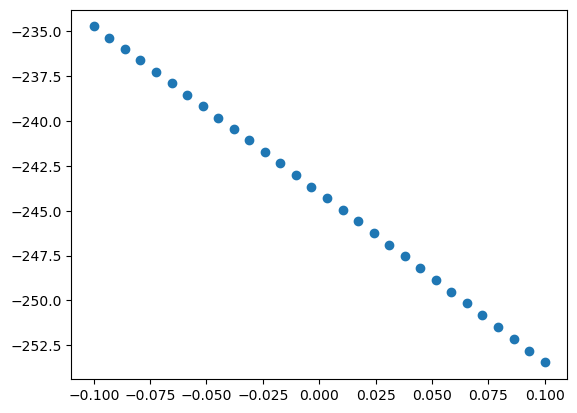

 25%|██▍       | 9997/40001 [03:58<10:20, 48.39it/s]

10000 curvature tensor(-4.3245, dtype=torch.float64, grad_fn=<DivBackward0>) 7.784369966249008 distance -0.10507155136014763 loss 167.7457944556703
trueloss 167.7457944556703
loss 167.7457944556703
tensor([-0.0646, -0.1148, -0.0975, -0.1072, -0.0644, -0.0494],
       dtype=torch.float64, grad_fn=<SubBackward0>)


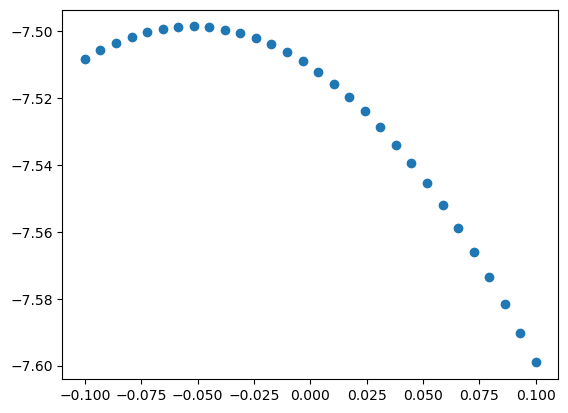

 50%|████▉     | 19998/40001 [07:29<06:34, 50.76it/s]

20000 curvature tensor(-4.6948, dtype=torch.float64, grad_fn=<DivBackward0>) 2.1006271206557363 distance -0.001131740749615737 loss 21.344535138240648
trueloss 21.344535138240648
loss 21.344535138240648
tensor([-0.0434, -0.0323, -0.0291, -0.0496, -0.0625, -0.0398],
       dtype=torch.float64, grad_fn=<SubBackward0>)


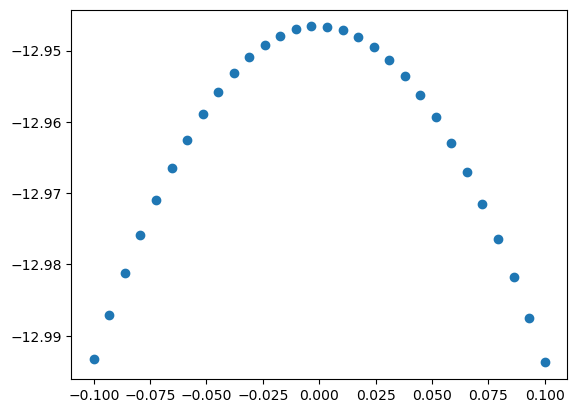

 75%|███████▍  | 29997/40001 [11:53<03:18, 50.34it/s]

30000 curvature tensor(5.1779, dtype=torch.float64, grad_fn=<DivBackward0>) 0.00028996830246214825 distance 0.0007469124972417767 loss 0.09915338329875995
trueloss 0.09915338329875995
loss 0.09915338329875995
tensor([0.0337, 0.0333, 0.0270, 0.0438, 0.0294, 0.0577], dtype=torch.float64,
       grad_fn=<SubBackward0>)


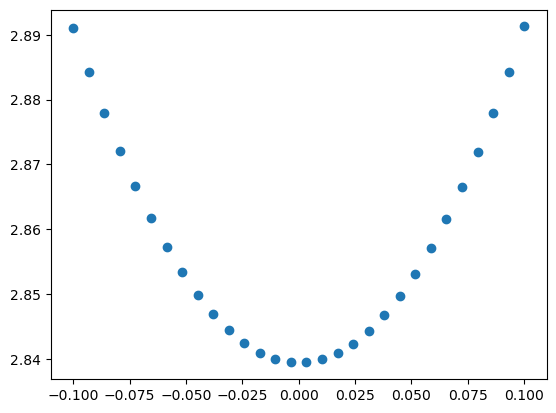

100%|█████████▉| 40000/40001 [15:14<00:00, 50.28it/s]

40000 curvature tensor(7.1275, dtype=torch.float64, grad_fn=<DivBackward0>) 0.0003199562741234593 distance 0.0007093554322455866 loss 0.00713404377071359
trueloss 0.00713404377071359
loss 0.00713404377071359
tensor([0.0388, 0.0593, 0.0921, 0.0466, 0.0438, 0.0884], dtype=torch.float64,
       grad_fn=<SubBackward0>)


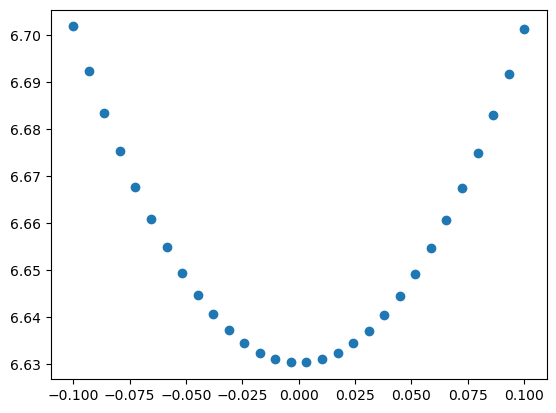

100%|██████████| 40001/40001 [15:14<00:00, 43.73it/s]


In [4]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 40001, 10000, 0.02, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


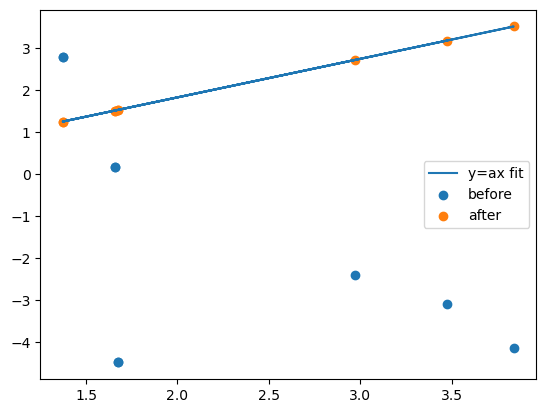

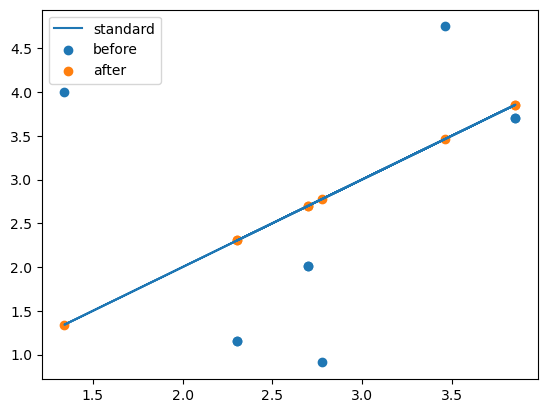

In [6]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()